In [262]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

df = pd.read_csv("data/u-churn-train.csv")

In [263]:
df = df.drop(columns=["customerID"])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [264]:
features_cate = ['gender','Partner','Dependents','PhoneService',
'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

for feature in features_cate:
    df[feature] = df[feature].astype('category')

X = df.drop(columns=["Churn"])  # 特征数据
y = df["Churn"]  # 目标变量

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [266]:
# 创建 LightGBM 数据集，并指定分类特征
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=features_cate)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=features_cate)

params = {
    "objective": "binary",  # 二分类任务
    "metric": ["binary_error", "auc"],  # 评估指标
    "boosting_type": "gbdt",  # GBDT 提升方法
    "learning_rate": 0.01,  # 学习率
    "num_leaves": 32,  # 叶节点数
    "max_depth": -1,  # 树的最大深度
    "verbosity": 0,  # 关闭日志输出
    "seed": 42  # 固定随机种子
}

In [267]:
callbacks = [lgb.early_stopping(stopping_rounds=300, verbose=True)]

model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data], callbacks=callbacks)

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's binary_error: 0.218085	valid_0's auc: 0.850718


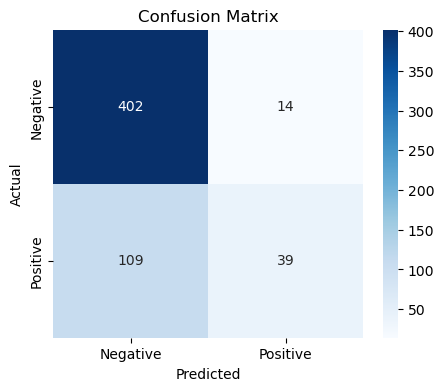

In [268]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

y_pred_binary = model.predict(X_test) > 0.5  # 阈值设为 0.5
cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()